## Modelo para Predição de Correntes de Fuga em Isoladores de Distribuição
#### Rafael Henrique Pinotti

### Problema

A qualidade no fornecimento de energia elétrica é uma preocupação constante das concessionárias, e um dos grandes problemas são falhas na transmissão e distribuição desta energia às unidades consumidoras.

Por estarem, normalmente, expostas às condições ambientais, as linhas de distribuição e transmissão de energia sofrem ação de agentes atmosféricos a todo o momento.

Um dos mais importantes equipamentos presente nas linhas são os isoladores elétricos, que têm a função de limitar a passagem de corrente elétrica permitindo a operação de forma segura de dispositivos e sistemas elétricos.

As falhas em isoladores elétricos são responsáveis por muitos desligamentos (não programados) na rede elétrica, e o monitoramento da saúde destes equipamentos permite uma manutenção preventiva mais eficiente.

Os dados coletados são provenientes da Dissertação de Mestrado de Milton Augusto Pinotti, defendida na Universidade Regional de Blumenau (Furb).

Pretende-se com esta análise encontrar um modelo para predição da corrente de fuga em isoladores elétricos, permitindo uma ação preventiva mais eficiente para este tipo de equipamento em sistemas de transmissão e distribuição de energia elétrica.

Os dados analisados foram coletados em uma EMSI (Estação de Monitoramento de Sistemas Isolantes) instalada em subestação elétrica da Celesc (Centrais Elétricas de Santa Catarina) na Praia Brava em Itajaí/SC.

Os dados foram coletados diariamente durante o mês de Fevereiro de 2010, totalizando 40.320 registros em 40 sistemas isolantes, realizando a medição das correntes de fuga e das condições atmosféricas no período.

### Criação do Modelo

#### Importação das Bibliotecas e Configurações Globais

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

#### Aquisição dos dados

In [2]:
# Importar dados de arquivo csv, onde o separador de campos é '.' e o separador de casas decimais é ','
df = pd.read_csv('dados/dados_isolador40.csv', sep=';', decimal=',')

#### Análise exploratória dos dados

In [3]:
# 5 primeiros registros do dataframe
df.head()

,umidade,temperatura,pressao,vento_ang,vent_veloc,chuva,corrente_fuga
0,70,29.6,1016,278,1.4,0,0.024992
1,69,29.7,1016,297,1.4,0,0.022767
2,70,29.8,1016,273,1.6,0,0.022607
3,68,29.8,1016,243,2.6,0,0.022426
4,68,29.7,1016,257,2.8,0,0.031797


In [4]:
# Formato do dataframe (registros/colunas)
df.shape

(40316, 7)

In [5]:
# Informações estatísticas do dataframe
df.describe()
# Notamos que existem atributos com valor mínimo igual a zero.

,umidade,temperatura,pressao,vento_ang,vent_veloc,chuva,corrente_fuga
count,40316.000000,40316.000000,40316.000000,40316.000000,40316.000000,40316.000000,40316.000000
mean,80.507069,27.179539,1013.934195,179.871738,1.433518,0.348274,0.036329
std,12.887528,3.133381,3.576448,99.311229,1.330448,2.700848,0.002511
min,34.000000,18.600000,1006.000000,0.000000,0.000000,0.000000,0.022426
25%,71.000000,25.200000,1011.000000,75.000000,0.000000,0.000000,0.035073
50%,85.000000,26.700000,1013.000000,210.000000,1.400000,0.000000,0.036337
75%,91.000000,29.200000,1017.000000,265.000000,2.400000,0.000000,0.037321
max,98.000000,37.400000,1022.000000,357.000000,11.900000,100.000000,0.105487


In [6]:
# Verificando se existem valores nulos/missing
df.isnull().values.any()

False

In [7]:
# Verificando a quantidade de registros nulos
df.isnull().sum()

umidade          0
temperatura      0
pressao          0
vento_ang        0
vent_veloc       0
chuva            0
corrente_fuga    0
dtype: int64

In [8]:
# Verificando a quantidade de registros com valor zero em cada atributo.
(df == 0).sum()
# Devido à quantidade de valores zerados no atributo chuva, em relação ao total de registros,
# verificar se o atributo exerce alguma influência no modelo.

umidade              0
temperatura          0
pressao              0
vento_ang           92
vent_veloc       14511
chuva            38064
corrente_fuga        0
dtype: int64

In [9]:
# Plotando a correlação entre os atributos
df.corr().style.format("{:.5}").background_gradient(cmap=plt.get_cmap('coolwarm'), axis=1)

,umidade,temperatura,pressao,vento_ang,vent_veloc,chuva,corrente_fuga
umidade,1.0,-0.44157,-0.20368,0.32259,-0.50396,0.11214,0.69658
temperatura,-0.44157,1.0,-0.39874,-0.43925,0.45762,-0.11037,-0.34919
pressao,-0.20368,-0.39874,1.0,-0.011539,-0.045943,0.044076,-0.064254
vento_ang,0.32259,-0.43925,-0.011539,1.0,-0.34307,0.0424,0.22667
vent_veloc,-0.50396,0.45762,-0.045943,-0.34307,1.0,-0.0043842,-0.3078
chuva,0.11214,-0.11037,0.044076,0.0424,-0.0043842,1.0,0.29679
corrente_fuga,0.69658,-0.34919,-0.064254,0.22667,-0.3078,0.29679,1.0


In [10]:
# Correlação da corrente de fuga com os demais atributos.
df.corr()['corrente_fuga']
# Verificamos que a pressão possui uma correlação muito baixa, verificar se faz alguma diferença no modelo.

umidade          0.696576
temperatura     -0.349192
pressao         -0.064254
vento_ang        0.226674
vent_veloc      -0.307804
chuva            0.296792
corrente_fuga    1.000000
Name: corrente_fuga, dtype: float64

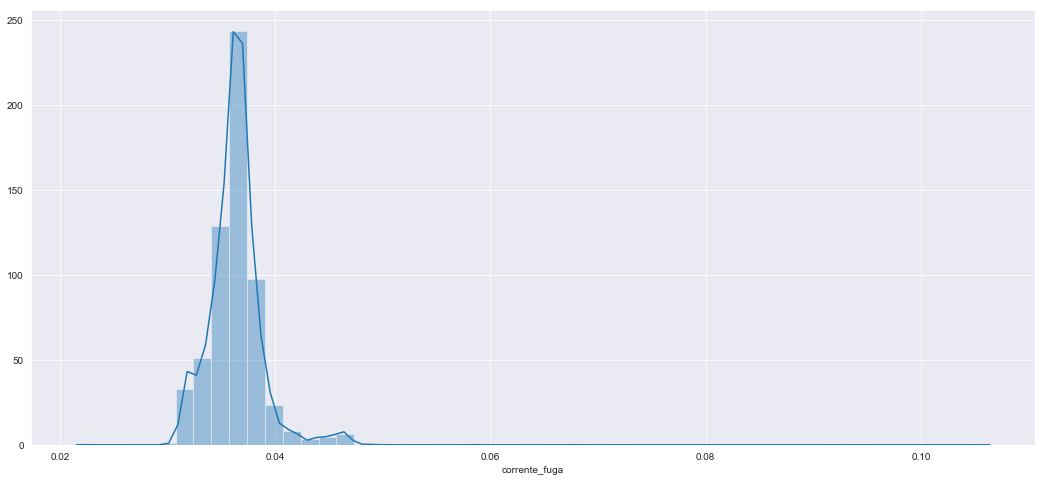

In [11]:
plt.figure(figsize=(18,8))
sns.set_style('darkgrid')
sns.distplot(df.corrente_fuga);
# A distribuição da corrente de fuga segue uma distribuição normal.

#### Preparação dos dados para o modelo

Apesar do atributo chuva possuir muitos registros com valor zero, e da baixa correlação da pressão, os dois atributos serão mantidos para a criação do modelo base.

In [12]:
# Excluindo a variável target 'corrente_fuga'.
cols = df.columns.drop(['corrente_fuga'])
cols

Index(['umidade', 'temperatura', 'pressao', 'vento_ang', 'vent_veloc',
       'chuva'],
      dtype='object')

In [13]:
# 80% dos dados para treino e 20% para teste.
# O parâmetro 'random_state' (semente aleatória) garante que os resultados sejam repetíveis em qualquer máquina.
X_train, X_test, y_train, y_test = train_test_split(df[cols], df['corrente_fuga'], test_size=0.20, random_state=42)

#### Criando os modelos de machine learning

##### 01. Regressão Linear

In [14]:
lr = LinearRegression()

In [15]:
# Treinando o modelo.
model_lr = lr.fit(X_train, y_train)
# Realizando a predição com os dados de teste.
result_lr = model_lr.predict(X_test)

Calculando o erro e computando o score para os dados de teste:

In [16]:
# MSE: média do erro quadrado. Quanto menor o valor, mais acertivo é o modelo.
mse_lr = mean_squared_error(y_test, result_lr)
# RMSE: raiz quadrada do MSE (facilita a visualização do valor).
rmse_lr = (np.sqrt(mse_lr))
# A métrica score varia entre 0 e 1, e indica percentualmente o quanto o modelo consegue explicar os valores observados.
# Quanto maior o valor mais explicativo é o modelo.
score_lr = model_lr.score(X_test, y_test)
print('Resultados do erro médio e score (acurácia do modelo) para o dataset de teste:\n  MSE: {}'.format(mse_lr) 
      + '\n RMSE: {}'.format(rmse_lr) 
      + '\nScore: {:2.3f}'.format(score_lr * 100) + '%')

Resultados do erro médio e score (acurácia do modelo) para o dataset de teste:
  MSE: 2.403077793817954e-06
 RMSE: 0.001550186373897653
Score: 58.168%


###### 02. Árvore de Decisão

In [17]:
tree = DecisionTreeRegressor()

In [18]:
model_tree = tree.fit(X_train, y_train)
result_tree = tree.predict(X_test)

In [19]:
mse_tree = mean_squared_error(y_test, result_tree)
rmse_tree = (np.sqrt(mse_tree))
score_tree = model_tree.score(X_test, y_test)
print('Resultados do erro médio e score (acurácia do modelo) para o dataset de treino:\n  MSE: {}'.format(mse_tree) 
      + '\n RMSE: {}'.format(rmse_tree) 
      + '\nScore: {:2.3f}'.format(score_tree * 100) + '%')

Resultados do erro médio e score (acurácia do modelo) para o dataset de treino:
  MSE: 8.168097763363829e-07
 RMSE: 0.0009037752908419122
Score: 85.781%


##### 03. Random Forest

In [20]:
tree_rf = RandomForestRegressor()

In [21]:
model_rf = tree_rf.fit(X_train, y_train)
result_rf = model_rf.predict(X_test)

In [22]:
mse_rf = mean_squared_error(y_test, result_rf)
rmse_rf = (np.sqrt(mse_rf))
score_rf = model_rf.score(X_test, y_test)
print('Resultados do erro médio e score (acurácia do modelo) para o dataset de treino:\n  MSE: {}'.format(mse_rf) 
      + '\n RMSE: {}'.format(rmse_rf) 
      + '\nScore: {:2.3f}'.format(score_rf * 100) + '%')

Resultados do erro médio e score (acurácia do modelo) para o dataset de treino:
  MSE: 7.053115721005886e-07
 RMSE: 0.0008398282991782241
Score: 87.722%


##### 04. Random Forest com ajustes nos hiperparâmetros

In [25]:
param = {'min_samples_leaf':[1,10],'min_samples_split':[2,10],'n_estimators':[100,250,500,750, 1000, 2500]}
rf = RandomForestRegressor()
grid = GridSearchCV(rf, param, n_jobs=4)

In [26]:
# Executando o grid
grid.fit(X_train, y_train)

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=4,
       param_grid={'min_samples_leaf': [1, 10], 'min_samples_split': [2, 10], 'n_estimators': [100, 250, 500, 750, 1000, 2500]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [27]:
# Verificando os melhores parâmetros
grid.best_params_

{'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 1000}

In [28]:
rf_best = grid.best_estimator_

In [29]:
result_grid = rf_best.predict(X_test)

In [30]:
mse_grid = mean_squared_error(y_test, result_grid)
rmse_grid = (np.sqrt(mse_grid))
score_grid = rf_best.score(X_test, y_test)
print('Resultados do erro médio e score (acurácia do modelo) para o dataset de treino:\n  MSE: {}'.format(mse_grid) 
      + '\n RMSE: {}'.format(rmse_grid) 
      + '\nScore: {:2.3f}'.format(score_grid * 100) + '%')

Resultados do erro médio e score (acurácia do modelo) para o dataset de treino:
  MSE: 5.490079314983229e-07
 RMSE: 0.0007409506943773809
Score: 90.443%


##### Comparando os scores

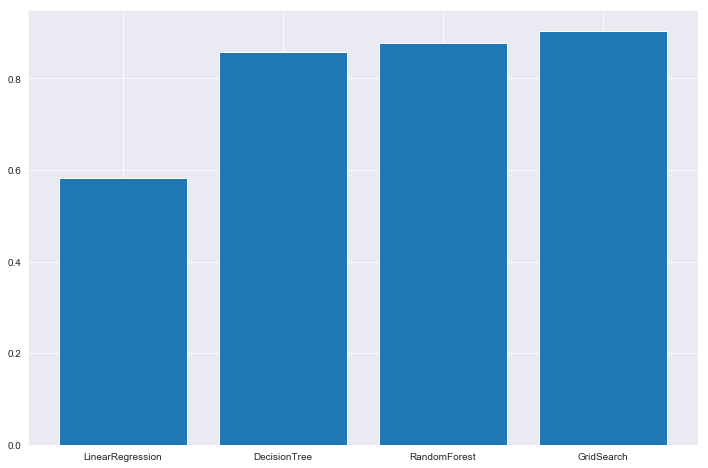

In [31]:
scores = [score_lr, score_tree, score_rf, score_grid]
labels = ['LinearRegression', 'DecisionTree', 'RandomForest', 'GridSearch']
plt.figure(figsize=(12,8))
plt.bar(labels, scores)

plt.show()